In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import h5py
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import wandb

from dl_utils.utils.dataset import split_train_valid, viz_dataloader, hdf5_dataset
from dl_utils.utils.utils import list_to_dict, find_last_epoch_file, sort_tasks_by_size

from dl_utils.training.build_model import resnet50_, fpn_resnet50_classification, xcit_small
from dl_utils.training.train_functions import train_epochs
from dl_utils.analysis.confusion_matrix import confusion_matrix, plot_cm
from dl_utils.packed_functions import generate_confusion_matrix_batch_full_val_set_add_noise

/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ResNet 50

/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


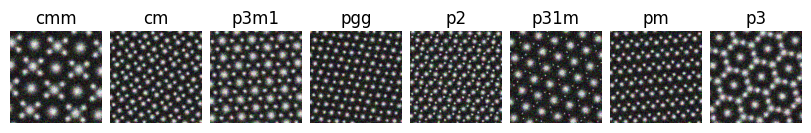

In [2]:
import torch
import torchvision.transforms as T
import numpy as np

class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1, clamp=True):
        self.mean = mean
        self.std = std
        self.clamp = clamp

    def __call__(self, tensor):
        noisy = tensor + torch.randn_like(tensor) * self.std + self.mean
        if self.clamp:
            noisy = torch.clamp(noisy, 0.0, 1.0)
        return noisy

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std}, clamp={self.clamp})"

transform = T.Compose([
    T.ToTensor(),
    AddGaussianNoise(mean=0.0, std=0.3),
])
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)
# atom
atom_ds = hdf5_dataset('../../../datasets/atom_v5_rot_1m_fix_vector.h5', folder='atom', transform=transform)
atom_dl = DataLoader(atom_ds, batch_size=32, shuffle=False, num_workers=1)
viz_dataloader(atom_dl, label_converter=label_converter, title='atom_dl')

In [3]:
task_orders = ['10m', '1k', '5k', '10k', '50k', '100k', '500k', '1m', '2m', '5m', ]
ds_size_list = [10000000, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 2000000, 5000000]
model_path_list = sort_tasks_by_size(glob.glob('../../../models/ResNet50/*'), task_orders)
print(model_path_list)

ds_path_info = {'imagenet': '../../../datasets/imagenet_v5_rot_10m_fix_vector.h5',
                'noise': '../../../datasets/noise_v5_rot_1m_fix_vector.h5',
                'atom': '../../../datasets/atom_v5_rot_1m_fix_vector.h5'}
running_specs = {'batch_size': 3500, 
                'num_workers': 12, 
                'save_path': '../../../results/ResNet50/',
                'device_ids': [6]}

['../../../models/ResNet50/03132025-ResNet50-benchmark-10m', '../../../models/ResNet50/03132025-ResNet50-benchmark-1k', '../../../models/ResNet50/03132025-ResNet50-benchmark-5k', '../../../models/ResNet50/03132025-ResNet50-benchmark-10k', '../../../models/ResNet50/03132025-ResNet50-benchmark-50k', '../../../models/ResNet50/03132025-ResNet50-benchmark-100k', '../../../models/ResNet50/03132025-ResNet50-benchmark-500k', '../../../models/ResNet50/03132025-ResNet50-benchmark-1m', '../../../models/ResNet50/03132025-ResNet50-benchmark-2m', '../../../models/ResNet50/03132025-ResNet50-benchmark-5m']


### only do the cross-validation on the full set, and add noise to imcrease the difficulty

Running on cuda:6
Loading model from ../../../models/ResNet50/03132025-ResNet50-benchmark-10m/epoch_23.pth


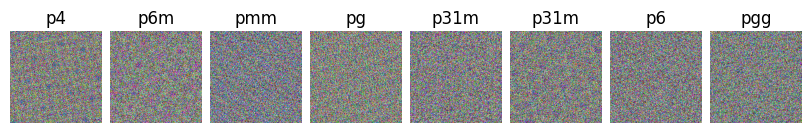

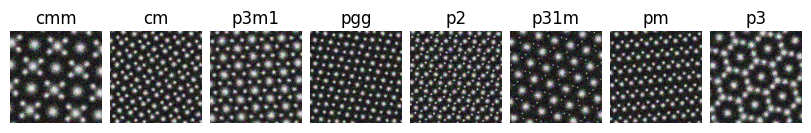

Confusion Matrix for 03132025-ResNet50-benchmark-10m:


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:25<00:00,  2.60s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 58.94%


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:21<00:00,  2.58s/it]

Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 12.98%
Loading model from ../../../models/ResNet50/03132025-ResNet50-benchmark-1k/epoch_200000.pth


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


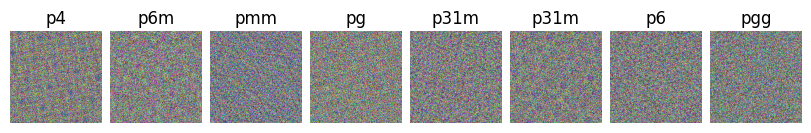

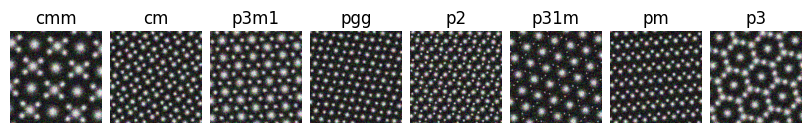

Confusion Matrix for 03132025-ResNet50-benchmark-1k:


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:29<00:00,  2.61s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 9.69%


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:25<00:00,  2.60s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 6.72%
Loading model from ../../../models/ResNet50/03132025-ResNet50-benchmark-5k/epoch_40000.pth


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


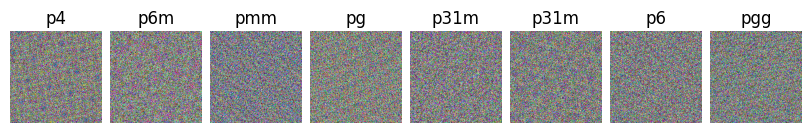

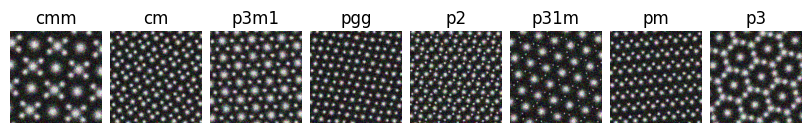

Confusion Matrix for 03132025-ResNet50-benchmark-5k:


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:22<00:00,  2.59s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 33.33%


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:21<00:00,  2.59s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 11.38%
Loading model from ../../../models/ResNet50/03132025-ResNet50-benchmark-10k/epoch_15300.pth


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


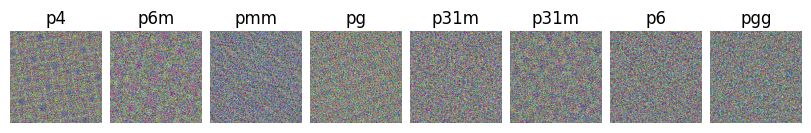

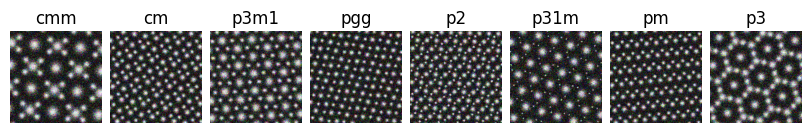

Confusion Matrix for 03132025-ResNet50-benchmark-10k:


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:58<00:00,  2.71s/it]

Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 37.78%


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:54<00:00,  2.70s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 10.98%
Loading model from ../../../models/ResNet50/03132025-ResNet50-benchmark-50k/epoch_4000.pth


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


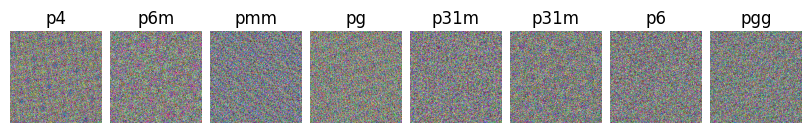

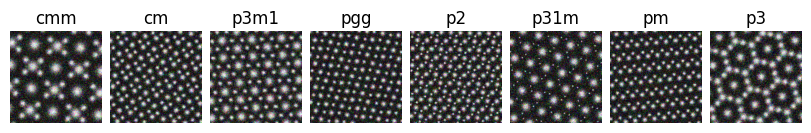

Confusion Matrix for 03132025-ResNet50-benchmark-50k:


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:18<00:00,  2.57s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 37.01%


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:19<00:00,  2.58s/it]

Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 11.99%
Loading model from ../../../models/ResNet50/03132025-ResNet50-benchmark-100k/epoch_1530.pth


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


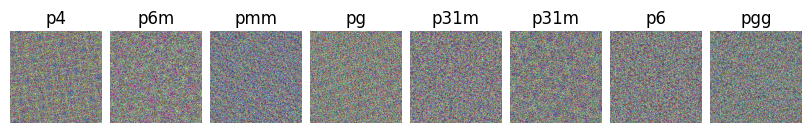

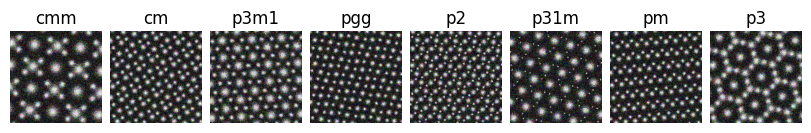

Confusion Matrix for 03132025-ResNet50-benchmark-100k:


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:21<00:00,  2.58s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 43.07%


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:20<00:00,  2.58s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 11.14%
Loading model from ../../../models/ResNet50/03132025-ResNet50-benchmark-500k/epoch_400.pth


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


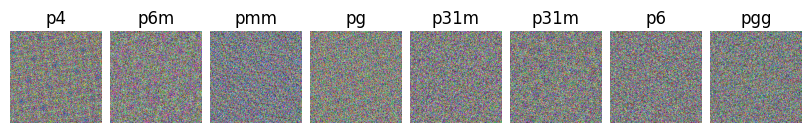

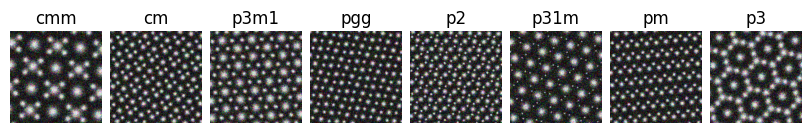

Confusion Matrix for 03132025-ResNet50-benchmark-500k:


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:24<00:00,  2.59s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 68.63%


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:14<00:00,  2.56s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 11.63%
Loading model from ../../../models/ResNet50/03132025-ResNet50-benchmark-1m/epoch_185-valid:loss=0.07,acc=0.98.pth


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


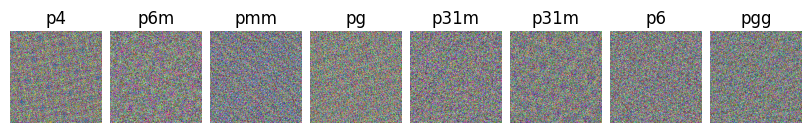

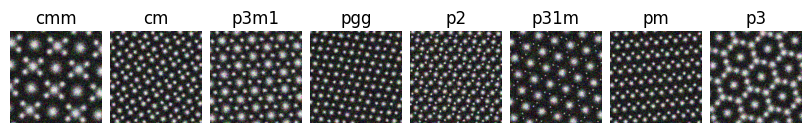

Confusion Matrix for 03132025-ResNet50-benchmark-1m:


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:16<00:00,  2.57s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 72.59%


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:21<00:00,  2.58s/it]

Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 11.62%
Loading model from ../../../models/ResNet50/03132025-ResNet50-benchmark-2m/epoch_100.pth


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


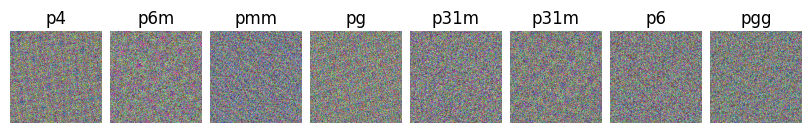

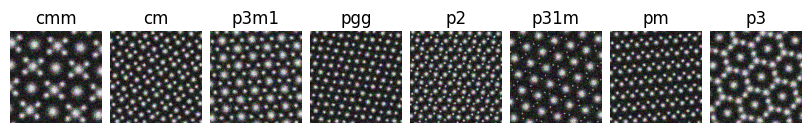

Confusion Matrix for 03132025-ResNet50-benchmark-2m:


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:14<00:00,  2.56s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 70.83%


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:17<00:00,  2.57s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 11.48%
Loading model from ../../../models/ResNet50/03132025-ResNet50-benchmark-5m/epoch_40.pth


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


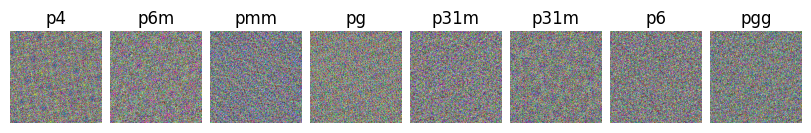

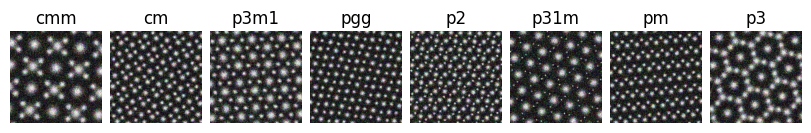

Confusion Matrix for 03132025-ResNet50-benchmark-5m:


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:21<00:00,  2.58s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 73.03%


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [12:17<00:00,  2.57s/it]


Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0  58900.0   

       p6m  
0  58900.0

Accuracy for these batches: 14.77%


In [4]:
model = resnet50_(3, 17)
stats = generate_confusion_matrix_batch_full_val_set_add_noise(model, model_path_list, ds_size_list, ds_path_info, running_specs, noise_std=0.3)

In [7]:
import pandas as pd
df = pd.read_csv('../../../results/history/training_summary_latest.csv')
df

Name     Model  Dataset_size  train_loss  valid_loss  \
0     ResNet50-1k  ResNet50          1000    0.024114    8.707681   
1     ResNet50-5k  ResNet50          5000    0.026530    3.826476   
2    ResNet50-10k  ResNet50         10000    0.028572    3.448092   
3    ResNet50-50k  ResNet50         50000    0.027217    1.041223   
4   ResNet50-100k  ResNet50        100000    0.136364    1.518383   
5   ResNet50-500k  ResNet50        500000    0.030453    0.143844   
6     ResNet50-1m  ResNet50       1000000    0.030649    0.090277   
7     ResNet50-2m  ResNet50       2000000    0.044772    0.053977   
8     ResNet50-5m  ResNet50       5000000    0.011643    0.020937   
9    ResNet50-10m  ResNet50      10000000    0.037016    0.036806   
10         FPN-1k       FPN          1000    0.000846    8.795190   
11        FPN-10k       FPN         10000    0.000305    3.226845   
12       FPN-100k       FPN        100000    0.001644    0.560978   
13       FPN-500k       FPN        500000    0.002160    0.108319   
14         FPN-1m       FPN       1000000    0.002628    0.069037   
15         FPN-2m       FPN       2000000    0.008375    0.042212   
16         FPN-5m       FPN       5000000    0.006962    0.020497   
17        FPN-10m       FPN      10000000    0.031929    0.039577   
18        XCiT-1k      XCiT          1000    0.000147   13.923977   
19        XCiT-5k      XCiT          5000    0.037746    5.230759   
20       XCiT-10k      XCiT         10000    0.076306    2.892839   
21       XCiT-50k      XCiT         50000    0.045721    0.259100   
22      XCiT-100k      XCiT        100000    0.001598    0.267760   
23      XCiT-500k      XCiT        500000    0.002475    0.060843   
24        XCiT-1m      XCiT       1000000    0.002574    0.045677   
25        XCiT-2m      XCiT       2000000    0.002518    0.036749   
26        XCiT-5m      XCiT       5000000    0.005595    0.015812   
27       XCiT-10m      XCiT      10000000    0.031414    0.035924   

    train_accuracy  valid_accuracy  noise_accuracy  noise_loss  atom_accuracy  \
0         0.990000        0.228000        0.079000    9.710158       0.124000   
1         0.990600        0.552800        0.359200    4.911996       0.359400   
2         0.990300        0.598800        0.368700    4.815066       0.414900   
3         0.990240        0.869840        0.588840    3.003041       0.388060   
4         0.958889        0.633200        0.114340    4.077415       0.393780   
5         0.989220        0.975808        0.885926    0.899102       0.703082   
6         0.989165        0.982200        0.938441    0.486521       0.745000   
7         0.985556        0.982848        0.940066    0.264464       0.780175   
8         0.997277        0.994947        0.935147    0.273390       0.842422   
9         0.986667        0.986712        0.961947    0.134230       0.883770   
10        1.000000        0.106977        0.062343    9.942680       0.069275   
11        0.999883        0.565096        0.142520    5.737493       0.413529   
12        0.999463        0.918445        0.434716    3.234451       0.557819   
13        0.999243        0.985995        0.868971    0.766391       0.665324   
14        0.999097        0.991460        0.922578    0.497664       0.774495   
15        0.997823        0.992023        0.928784    0.342222       0.769868   
16        0.997817        0.995589        0.953284    0.237720       0.813172   
17        0.988320        0.986798        0.965398    0.196351       0.851656   
18        1.000000        0.074419        0.056392   14.736371       0.052098   
19        0.987500        0.400000        0.094000    8.100603       0.157800   
20        0.980000        0.564400        0.092100    6.928162       0.225100   
21        0.990000        0.951120        0.776700    1.296565       0.691180   
22        0.999370        0.963727        0.718510    2.094841       0.659725   
23        0.999119        0.993102        0.944157    0.361368     

In [8]:
acc_update_dict = stats

# Helper to convert Dataset_size into suffix (1k, 5k, 1m, etc.)
def size_suffix(size):
    if size >= 1_000_000:
        return f"{int(size / 1_000_000)}m"
    elif size >= 1000:
        return f"{int(size / 1000)}k"
    else:
        return str(size)

# Update DataFrame
for i, row in df.iterrows():
    model_name = row['Model']
    size = size_suffix(row['Dataset_size'])
    dict_key = f"03132025-{model_name}-benchmark-{size}"
    
    if dict_key in acc_update_dict:
        atom_cv_key = f"{dict_key}-atom_cv"
        noise_cv_key = f"{dict_key}-noise_cv"
        df.at[i, 'atom_accuracy'] = acc_update_dict[dict_key].get(atom_cv_key, row['atom_accuracy'])
        df.at[i, 'noise_accuracy'] = acc_update_dict[dict_key].get(noise_cv_key, row['noise_accuracy'])

df

Name     Model  Dataset_size  train_loss  valid_loss  \
0     ResNet50-1k  ResNet50          1000    0.024114    8.707681   
1     ResNet50-5k  ResNet50          5000    0.026530    3.826476   
2    ResNet50-10k  ResNet50         10000    0.028572    3.448092   
3    ResNet50-50k  ResNet50         50000    0.027217    1.041223   
4   ResNet50-100k  ResNet50        100000    0.136364    1.518383   
5   ResNet50-500k  ResNet50        500000    0.030453    0.143844   
6     ResNet50-1m  ResNet50       1000000    0.030649    0.090277   
7     ResNet50-2m  ResNet50       2000000    0.044772    0.053977   
8     ResNet50-5m  ResNet50       5000000    0.011643    0.020937   
9    ResNet50-10m  ResNet50      10000000    0.037016    0.036806   
10         FPN-1k       FPN          1000    0.000846    8.795190   
11        FPN-10k       FPN         10000    0.000305    3.226845   
12       FPN-100k       FPN        100000    0.001644    0.560978   
13       FPN-500k       FPN        500000    0.002160    0.108319   
14         FPN-1m       FPN       1000000    0.002628    0.069037   
15         FPN-2m       FPN       2000000    0.008375    0.042212   
16         FPN-5m       FPN       5000000    0.006962    0.020497   
17        FPN-10m       FPN      10000000    0.031929    0.039577   
18        XCiT-1k      XCiT          1000    0.000147   13.923977   
19        XCiT-5k      XCiT          5000    0.037746    5.230759   
20       XCiT-10k      XCiT         10000    0.076306    2.892839   
21       XCiT-50k      XCiT         50000    0.045721    0.259100   
22      XCiT-100k      XCiT        100000    0.001598    0.267760   
23      XCiT-500k      XCiT        500000    0.002475    0.060843   
24        XCiT-1m      XCiT       1000000    0.002574    0.045677   
25        XCiT-2m      XCiT       2000000    0.002518    0.036749   
26        XCiT-5m      XCiT       5000000    0.005595    0.015812   
27       XCiT-10m      XCiT      10000000    0.031414    0.035924   

    train_accuracy  valid_accuracy  noise_accuracy  noise_loss  atom_accuracy  \
0         0.990000        0.228000        0.067243    9.710158       0.096874   
1         0.990600        0.552800        0.113783    4.911996       0.333306   
2         0.990300        0.598800        0.109847    4.815066       0.377777   
3         0.990240        0.869840        0.119873    3.003041       0.370122   
4         0.958889        0.633200        0.111417    4.077415       0.430721   
5         0.989220        0.975808        0.116252    0.899102       0.686338   
6         0.989165        0.982200        0.116231    0.486521       0.725937   
7         0.985556        0.982848        0.114849    0.264464       0.708349   
8         0.997277        0.994947        0.147743    0.273390       0.730323   
9         0.986667        0.986712        0.129766    0.134230       0.589406   
10        1.000000        0.106977        0.062343    9.942680       0.069275   
11        0.999883        0.565096        0.142520    5.737493       0.413529   
12        0.999463        0.918445        0.434716    3.234451       0.557819   
13        0.999243        0.985995        0.868971    0.766391       0.665324   
14        0.999097        0.991460        0.922578    0.497664       0.774495   
15        0.997823        0.992023        0.928784    0.342222       0.769868   
16        0.997817        0.995589        0.953284    0.237720       0.813172   
17        0.988320        0.986798        0.965398    0.196351       0.851656   
18        1.000000        0.074419        0.056392   14.736371       0.052098   
19        0.987500        0.400000        0.094000    8.100603       0.157800   
20        0.980000        0.564400        0.092100    6.928162       0.225100   
21        0.990000        0.951120        0.776700    1.296565       0.691180   
22        0.999370        0.963727        0.718510    2.094841       0.659725   
23        0.999119        0.993102        0.944157    0.361368     

In [9]:
df.to_csv('../../../results/history/training_summary_latest_full_val_add_noise_p3.csv', index=False)

### std=0.1

In [4]:
stats

{'03132025-ResNet50-benchmark-10m': {'03132025-ResNet50-benchmark-10m-atom_cv': 0.8541855587735944,
  '03132025-ResNet50-benchmark-10m-noise_cv': 0.8010196744232497},
 '03132025-ResNet50-benchmark-1k': {'03132025-ResNet50-benchmark-1k-atom_cv': 0.10144012783381604,
  '03132025-ResNet50-benchmark-1k-noise_cv': 0.08137720962748426},
 '03132025-ResNet50-benchmark-5k': {'03132025-ResNet50-benchmark-5k-atom_cv': 0.35483970837910717,
  '03132025-ResNet50-benchmark-5k-noise_cv': 0.27429941076600417},
 '03132025-ResNet50-benchmark-10k': {'03132025-ResNet50-benchmark-10k-atom_cv': 0.4000329571556976,
  '03132025-ResNet50-benchmark-10k-noise_cv': 0.2900459402776391},
 '03132025-ResNet50-benchmark-50k': {'03132025-ResNet50-benchmark-50k-atom_cv': 0.3832278038549885,
  '03132025-ResNet50-benchmark-50k-noise_cv': 0.4225237191650854},
 '03132025-ResNet50-benchmark-100k': {'03132025-ResNet50-benchmark-100k-atom_cv': 0.44113652252072305,
  '03132025-ResNet50-benchmark-100k-noise_cv': 0.506457605113352

In [6]:
import pandas as pd

In [19]:
df = pd.read_csv('../../../results/history/training_summary_latest.csv')
df

Name     Model  Dataset_size  train_loss  valid_loss  \
0     ResNet50-1k  ResNet50          1000    0.024114    8.707681   
1     ResNet50-5k  ResNet50          5000    0.026530    3.826476   
2    ResNet50-10k  ResNet50         10000    0.028572    3.448092   
3    ResNet50-50k  ResNet50         50000    0.027217    1.041223   
4   ResNet50-100k  ResNet50        100000    0.136364    1.518383   
5   ResNet50-500k  ResNet50        500000    0.030453    0.143844   
6     ResNet50-1m  ResNet50       1000000    0.030649    0.090277   
7     ResNet50-2m  ResNet50       2000000    0.044772    0.053977   
8     ResNet50-5m  ResNet50       5000000    0.011643    0.020937   
9    ResNet50-10m  ResNet50      10000000    0.037016    0.036806   
10         FPN-1k       FPN          1000    0.000846    8.795190   
11        FPN-10k       FPN         10000    0.000305    3.226845   
12       FPN-100k       FPN        100000    0.001644    0.560978   
13       FPN-500k       FPN        500000    0.002160    0.108319   
14         FPN-1m       FPN       1000000    0.002628    0.069037   
15         FPN-2m       FPN       2000000    0.008375    0.042212   
16         FPN-5m       FPN       5000000    0.006962    0.020497   
17        FPN-10m       FPN      10000000    0.031929    0.039577   
18        XCiT-1k      XCiT          1000    0.000147   13.923977   
19        XCiT-5k      XCiT          5000    0.037746    5.230759   
20       XCiT-10k      XCiT         10000    0.076306    2.892839   
21       XCiT-50k      XCiT         50000    0.045721    0.259100   
22      XCiT-100k      XCiT        100000    0.001598    0.267760   
23      XCiT-500k      XCiT        500000    0.002475    0.060843   
24        XCiT-1m      XCiT       1000000    0.002574    0.045677   
25        XCiT-2m      XCiT       2000000    0.002518    0.036749   
26        XCiT-5m      XCiT       5000000    0.005595    0.015812   
27       XCiT-10m      XCiT      10000000    0.031414    0.035924   

    train_accuracy  valid_accuracy  noise_accuracy  noise_loss  atom_accuracy  \
0         0.990000        0.228000        0.079000    9.710158       0.124000   
1         0.990600        0.552800        0.359200    4.911996       0.359400   
2         0.990300        0.598800        0.368700    4.815066       0.414900   
3         0.990240        0.869840        0.588840    3.003041       0.388060   
4         0.958889        0.633200        0.114340    4.077415       0.393780   
5         0.989220        0.975808        0.885926    0.899102       0.703082   
6         0.989165        0.982200        0.938441    0.486521       0.745000   
7         0.985556        0.982848        0.940066    0.264464       0.780175   
8         0.997277        0.994947        0.935147    0.273390       0.842422   
9         0.986667        0.986712        0.961947    0.134230       0.883770   
10        1.000000        0.106977        0.062343    9.942680       0.069275   
11        0.999883        0.565096        0.142520    5.737493       0.413529   
12        0.999463        0.918445        0.434716    3.234451       0.557819   
13        0.999243        0.985995        0.868971    0.766391       0.665324   
14        0.999097        0.991460        0.922578    0.497664       0.774495   
15        0.997823        0.992023        0.928784    0.342222       0.769868   
16        0.997817        0.995589        0.953284    0.237720       0.813172   
17        0.988320        0.986798        0.965398    0.196351       0.851656   
18        1.000000        0.074419        0.056392   14.736371       0.052098   
19        0.987500        0.400000        0.094000    8.100603       0.157800   
20        0.980000        0.564400        0.092100    6.928162       0.225100   
21        0.990000        0.951120        0.776700    1.296565       0.691180   
22        0.999370        0.963727        0.718510    2.094841       0.659725   
23        0.999119        0.993102        0.944157    0.361368     

In [9]:
acc_update_dict = stats

In [12]:
stats

{'03132025-ResNet50-benchmark-10m': {'03132025-ResNet50-benchmark-10m-atom_cv': 0.8541855587735944,
  '03132025-ResNet50-benchmark-10m-noise_cv': 0.8010196744232497},
 '03132025-ResNet50-benchmark-1k': {'03132025-ResNet50-benchmark-1k-atom_cv': 0.10144012783381604,
  '03132025-ResNet50-benchmark-1k-noise_cv': 0.08137720962748426},
 '03132025-ResNet50-benchmark-5k': {'03132025-ResNet50-benchmark-5k-atom_cv': 0.35483970837910717,
  '03132025-ResNet50-benchmark-5k-noise_cv': 0.27429941076600417},
 '03132025-ResNet50-benchmark-10k': {'03132025-ResNet50-benchmark-10k-atom_cv': 0.4000329571556976,
  '03132025-ResNet50-benchmark-10k-noise_cv': 0.2900459402776391},
 '03132025-ResNet50-benchmark-50k': {'03132025-ResNet50-benchmark-50k-atom_cv': 0.3832278038549885,
  '03132025-ResNet50-benchmark-50k-noise_cv': 0.4225237191650854},
 '03132025-ResNet50-benchmark-100k': {'03132025-ResNet50-benchmark-100k-atom_cv': 0.44113652252072305,
  '03132025-ResNet50-benchmark-100k-noise_cv': 0.506457605113352

In [21]:

# Helper to convert Dataset_size into suffix (1k, 5k, 1m, etc.)
def size_suffix(size):
    if size >= 1_000_000:
        return f"{int(size / 1_000_000)}m"
    elif size >= 1000:
        return f"{int(size / 1000)}k"
    else:
        return str(size)

# Update DataFrame
for i, row in df.iterrows():
    model_name = row['Model']
    size = size_suffix(row['Dataset_size'])
    dict_key = f"03132025-{model_name}-benchmark-{size}"
    
    if dict_key in acc_update_dict:
        atom_cv_key = f"{dict_key}-atom_cv"
        noise_cv_key = f"{dict_key}-noise_cv"
        df.at[i, 'atom_accuracy'] = acc_update_dict[dict_key].get(atom_cv_key, row['atom_accuracy'])
        df.at[i, 'noise_accuracy'] = acc_update_dict[dict_key].get(noise_cv_key, row['noise_accuracy'])

df

Name     Model  Dataset_size  train_loss  valid_loss  \
0     ResNet50-1k  ResNet50          1000    0.024114    8.707681   
1     ResNet50-5k  ResNet50          5000    0.026530    3.826476   
2    ResNet50-10k  ResNet50         10000    0.028572    3.448092   
3    ResNet50-50k  ResNet50         50000    0.027217    1.041223   
4   ResNet50-100k  ResNet50        100000    0.136364    1.518383   
5   ResNet50-500k  ResNet50        500000    0.030453    0.143844   
6     ResNet50-1m  ResNet50       1000000    0.030649    0.090277   
7     ResNet50-2m  ResNet50       2000000    0.044772    0.053977   
8     ResNet50-5m  ResNet50       5000000    0.011643    0.020937   
9    ResNet50-10m  ResNet50      10000000    0.037016    0.036806   
10         FPN-1k       FPN          1000    0.000846    8.795190   
11        FPN-10k       FPN         10000    0.000305    3.226845   
12       FPN-100k       FPN        100000    0.001644    0.560978   
13       FPN-500k       FPN        500000    0.002160    0.108319   
14         FPN-1m       FPN       1000000    0.002628    0.069037   
15         FPN-2m       FPN       2000000    0.008375    0.042212   
16         FPN-5m       FPN       5000000    0.006962    0.020497   
17        FPN-10m       FPN      10000000    0.031929    0.039577   
18        XCiT-1k      XCiT          1000    0.000147   13.923977   
19        XCiT-5k      XCiT          5000    0.037746    5.230759   
20       XCiT-10k      XCiT         10000    0.076306    2.892839   
21       XCiT-50k      XCiT         50000    0.045721    0.259100   
22      XCiT-100k      XCiT        100000    0.001598    0.267760   
23      XCiT-500k      XCiT        500000    0.002475    0.060843   
24        XCiT-1m      XCiT       1000000    0.002574    0.045677   
25        XCiT-2m      XCiT       2000000    0.002518    0.036749   
26        XCiT-5m      XCiT       5000000    0.005595    0.015812   
27       XCiT-10m      XCiT      10000000    0.031414    0.035924   

    train_accuracy  valid_accuracy  noise_accuracy  noise_loss  atom_accuracy  \
0         0.990000        0.228000        0.081377    9.710158       0.101440   
1         0.990600        0.552800        0.274299    4.911996       0.354840   
2         0.990300        0.598800        0.290046    4.815066       0.400033   
3         0.990240        0.869840        0.422524    3.003041       0.383228   
4         0.958889        0.633200        0.506458    4.077415       0.441137   
5         0.989220        0.975808        0.677765    0.899102       0.705223   
6         0.989165        0.982200        0.763990    0.486521       0.743865   
7         0.985556        0.982848        0.766384    0.264464       0.784189   
8         0.997277        0.994947        0.819203    0.273390       0.854681   
9         0.986667        0.986712        0.801020    0.134230       0.854186   
10        1.000000        0.106977        0.062343    9.942680       0.069275   
11        0.999883        0.565096        0.142520    5.737493       0.413529   
12        0.999463        0.918445        0.434716    3.234451       0.557819   
13        0.999243        0.985995        0.868971    0.766391       0.665324   
14        0.999097        0.991460        0.922578    0.497664       0.774495   
15        0.997823        0.992023        0.928784    0.342222       0.769868   
16        0.997817        0.995589        0.953284    0.237720       0.813172   
17        0.988320        0.986798        0.965398    0.196351       0.851656   
18        1.000000        0.074419        0.056392   14.736371       0.052098   
19        0.987500        0.400000        0.094000    8.100603       0.157800   
20        0.980000        0.564400        0.092100    6.928162       0.225100   
21        0.990000        0.951120        0.776700    1.296565       0.691180   
22        0.999370        0.963727        0.718510    2.094841       0.659725   
23        0.999119        0.993102        0.944157    0.361368     

In [23]:
df.to_csv('../../../results/history/training_summary_latest_full_val_add_noise_p1.csv', index=False)